In [102]:
import pandas as pd
import glob
import re
import os

In [103]:


# Path to the directory containing the CSV files
# Replace this with your directory path
path = './linear_model'  # Current directory, modify as needed

# Get all CSV files that match the pattern
csv_files = glob.glob(os.path.join(path, 'qhaplo_*qtl_*n_scklrr_corr_summary.txt'))

# Create an empty list to store individual dataframes
dfs = []

# Process each file
for file in csv_files:
    # Extract the filename from the path
    filename = os.path.basename(file)

    # Extract parameters using regex
    # Pattern looks for numbers after 'qtl_' and before 'n_'
    qtl_match = re.search(r'(\d+)qtl', filename)
    n_match = re.search(r'(\d+)n', filename)

    if qtl_match and n_match:
        qtl_value = int(qtl_match.group(1))
        n_value = int(n_match.group(1))

        # Read the CSV file
        df = pd.read_csv(file)

        # Add columns for the parameters
        df['qtl_param'] = qtl_value
        df['n_param'] = n_value

        # Add the dataframe to our list
        dfs.append(df)
    else:
        print(f"Couldn't extract parameters from {filename}")

# Combine all dataframes into one
if dfs:
    linear_df = pd.concat(dfs, ignore_index=True)

    # Display the first few rows of the combined dataframe
    print(linear_df.head())

    # Save the combined dataframe to a new CSV if needed
    # combined_df.to_csv('combined_summary.csv', index=False)
else:
    print("No matching files found or parameters couldn't be extracted")

   trait  pearson_corr_pheno_mean  pearson_corr_pheno_std  \
0      1                 0.999448                0.000028   
1      2                 0.451642                0.021974   
2      1                 0.999498                0.000026   
3      2                 0.595083                0.021236   
4      1                 0.999499                0.000007   

   pearson_corr_beta_mean  pearson_corr_beta_std  best_lambda_mean  \
0                0.999936           1.199741e-06          0.220513   
1                0.869200           2.664051e-03        599.484250   
2                0.999995           3.034676e-07          0.021544   
3                0.989694           9.830175e-04         46.415888   
4                0.999994           1.606871e-07          0.266707   

   best_lambda_std  qtl_param  n_param  
0     0.000000e+00       1000    10000  
1     1.198364e-13       1000    10000  
2     0.000000e+00        100    10000  
3     0.000000e+00        100    10000  
4     2

In [114]:


# Path to the directory containing the CSV files
# Replace this with your directory path
path = './gpnet'  # Current directory, modify as needed

# Get all CSV files that match the pattern
csv_files = glob.glob(os.path.join(path, 'qhaplo_*qtl_*n_phenotype_correlations_untuned.csv'))

# Create an empty list to store individual dataframes
dfs = []

# Process each file
for file in csv_files:
    # Extract the filename from the path
    filename = os.path.basename(file)

    # Extract parameters using regex
    # Pattern looks for numbers after 'qtl_' and before 'n_'
    qtl_match = re.search(r'(\d+)qtl', filename)
    n_match = re.search(r'(\d+)n', filename)

    if qtl_match and n_match:
        qtl_value = int(qtl_match.group(1))
        n_value = int(n_match.group(1))

        # Read the CSV file
        df = pd.read_csv(file)

        # Add columns for the parameters
        df['qtl_param'] = qtl_value
        df['n_param'] = n_value

        # Add the dataframe to our list
        dfs.append(df)
    else:
        print(f"Couldn't extract parameters from {filename}")

# Combine all dataframes into one
if dfs:
    neural_df = pd.concat(dfs, ignore_index=True)

    # Display the first few rows of the combined dataframe
    print(neural_df.head())

    # Save the combined dataframe to a new CSV if needed
    # combined_df.to_csv('combined_summary.csv', index=False)
else:
    print("No matching files found or parameters couldn't be extracted")

   trait_number  pearson_correlation  true_mean  pred_mean  true_std  \
0             1             0.997717  -0.002230  -0.063188  1.747708   
1             2             0.439720  -0.014289  -0.219595  1.703334   
2             1             0.776732  -0.002722  -0.127419  1.699201   
3             2             0.235979  -0.011103   0.220300  1.751004   
4             1             0.997716   0.017076   0.193657  1.733299   

   pred_std  qtl_param  n_param  
0  1.681381       1000    10000  
1  1.044269       1000    10000  
2  1.223408      10000    10000  
3  0.894661      10000    10000  
4  1.747855       1000   100000  


In [115]:
linear_df.rename(columns={'pearson_corr_pheno_mean':'pearson_correlation'}, inplace=True)
linear_df.rename(columns={'trait':'trait_number'}, inplace=True)
neural_df.rename(columns={'pearson_correlation':'pearson_correlation'}, inplace=True)


In [116]:
neural_df

,trait_number,pearson_correlation,true_mean,pred_mean,true_std,pred_std,qtl_param,n_param
0,1,0.997717,-0.002230,-0.063188,1.747708,1.681381,1000,10000
1,2,0.439720,-0.014289,-0.219595,1.703334,1.044269,1000,10000
2,1,0.776732,-0.002722,-0.127419,1.699201,1.223408,10000,10000
3,2,0.235979,-0.011103,0.220300,1.751004,0.894661,10000,10000
4,1,0.997716,0.017076,0.193657,1.733299,1.747855,1000,100000
5,2,0.551831,-0.023328,0.187456,1.731667,1.214239,1000,100000
6,1,0.674730,-0.075494,-0.190723,1.656103,0.937340,1000,1000
7,2,0.223243,0.125463,-0.039649,1.757569,0.722708,1000,1000
8,1,0.999200,-0.009351,0.043172,1.743588,1.438687,100,100000
9,2,0.967089,0.004643,0.148873,1.714068,1.753237,100,100000


In [117]:
def get_parameter_combinations(df1, df2):
    # Get all unique combinations from both dataframes
    params1 = df1[['qtl_param', 'n_param', 'trait_number']].drop_duplicates()
    params2 = df2[['qtl_param', 'n_param', 'trait_number']].drop_duplicates()

    # Find common combinations using merge
    common_params = pd.merge(params1, params2, on=['qtl_param', 'n_param', 'trait_number'])

    return common_params

# Get common parameter combinations
common_params = get_parameter_combinations(linear_df, neural_df)


In [118]:
comparison_data = []

for _, row in common_params.iterrows():
    qtl = row['qtl_param']
    n = row['n_param']
    trait = row['trait_number']

    linear_row = linear_df[(linear_df['qtl_param'] == qtl) &
                           (linear_df['n_param'] == n) &
                           (linear_df['trait_number'] == trait)]

    neural_row = neural_df[(neural_df['qtl_param'] == qtl) &
                           (neural_df['n_param'] == n) &
                           (neural_df['trait_number'] == trait)]

    if not linear_row.empty and not neural_row.empty:
        comparison_data.append({
            'qtl_param': qtl,
            'n_param': n,
            'trait_number': trait,
            'linear_correlation': linear_row['pearson_correlation'].values[0],
            'neural_correlation': neural_row['pearson_correlation'].values[0],
            'difference': neural_row['pearson_correlation'].values[0] - linear_row['pearson_correlation'].values[0]
        })

comparison_df = pd.DataFrame(comparison_data)

# Display the comparison dataframe
print("Comparison of Linear and Neural Network Models:")
comparison_df


Comparison of Linear and Neural Network Models:


,qtl_param,n_param,trait_number,linear_correlation,neural_correlation,difference
0,1000,10000,1,0.999448,0.997717,-0.001732
1,1000,10000,2,0.451642,0.439720,-0.011922
2,100,10000,1,0.999498,0.999016,-0.000482
3,100,10000,2,0.595083,0.947050,0.351967
4,1000,100000,1,0.999499,0.997716,-0.001783
5,1000,100000,2,0.564030,0.551831,-0.012200
6,100,1000,1,0.999454,0.997214,-0.002240
7,100,1000,2,0.464824,0.573186,0.108362
8,1000,1000,1,0.897240,0.674730,-0.222509
9,1000,1000,2,0.300285,0.223243,-0.077043


In [119]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_difference_heatmap1(comparison_df):
    # Pivot the data to create a heatmap
    # We need to have qtl_param and n_param as indices, and trait_number as columns
    pivoted_data = comparison_df.pivot_table(
        index=['qtl_param', 'n_param'],
        columns='trait_number',
        values='difference',
        aggfunc='mean'  # In case there are duplicates
    )

    # Create the heatmap
    plt.figure(figsize=(10, 8))
    heatmap = sns.heatmap(
        pivoted_data,
        annot=True,
        cmap='RdBu_r',  # Red-Blue colormap, reversed (blue for positive)
        center=0,       # Center the colormap at 0
        fmt='.3f',      # Format annotations to 3 decimal places
        linewidths=.5,  # Add lines between cells
        cbar_kws={'label': 'Difference (Neural - Linear)'}
    )

    plt.title('Difference in Pearson Correlation (Neural Network - Linear Model)', fontsize=14, pad=20)
    plt.xlabel('Trait Number', fontsize=12, labelpad=10)
    plt.ylabel('Parameter Combination (qtl_param, n_param)', fontsize=12, labelpad=10)

    plt.tight_layout()
    return plt.gcf()

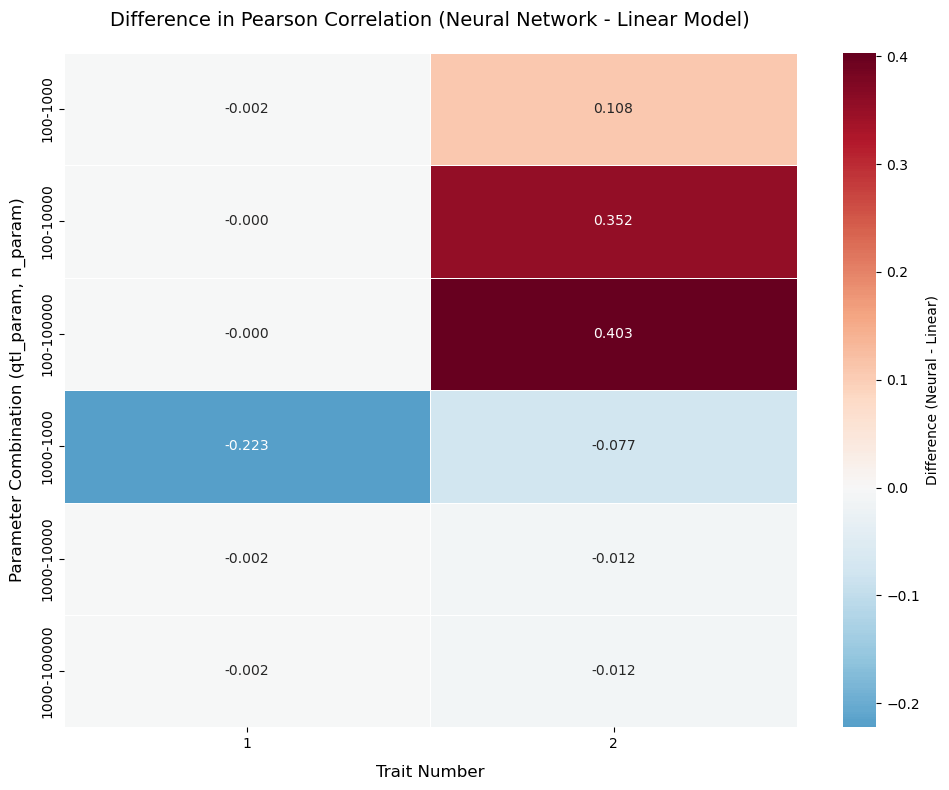

In [120]:
pl1 = plot_difference_heatmap1(comparison_df)
pl1.show()

In [121]:
def plot_difference_heatmap(comparison_df):
    """
    Creates separate side-by-side heatmaps for each trait with QTL on x-axis and sample size on y-axis.
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np

    # Get unique traits, QTL parameters, and sample sizes
    unique_traits = sorted(comparison_df['trait_number'].unique())
    unique_qtls = sorted(comparison_df['qtl_param'].unique())
    unique_n = sorted(comparison_df['n_param'].unique())

    num_traits = len(unique_traits)

    # Create a figure with subplots (one for each trait)
    fig, axes = plt.subplots(1, num_traits, figsize=(5*num_traits, 6), sharey=True)

    # If there's only one trait, axes won't be an array
    if num_traits == 1:
        axes = [axes]

    # Define a custom diverging colormap (blue for positive, red for negative)
    cmap = sns.diverging_palette(240, 10, as_cmap=True)

    # Find global min and max for consistent color scale
    vmin = comparison_df['difference'].min()
    vmax = comparison_df['difference'].max()

    # Ensure the colormap is centered at zero
    abs_max = max(abs(vmin), abs(vmax))
    vmin, vmax = -abs_max, abs_max

    for i, trait in enumerate(unique_traits):
        # Filter data for this trait
        trait_data = comparison_df[comparison_df['trait_number'] == trait]

        # Create a pivot table with QTL on x-axis and sample size on y-axis
        pivot_data = trait_data.pivot_table(
            index='n_param',
            columns='qtl_param',
            values='difference'
        )

        # Plot the heatmap
        sns.heatmap(
            pivot_data,
            ax=axes[i],
            cmap=cmap,
            vmin=vmin,
            vmax=vmax,
            center=0,
            annot=True,           # Show the values in cells
            fmt=".3f",            # Format of the annotations
            linewidths=0.5,       # Width of the lines between cells
            cbar=True if i == num_traits-1 else False  # Only show colorbar for the last plot
        )

        # Set title and labels
        axes[i].set_title(f'Trait {trait}')
        axes[i].set_xlabel('QTL Number')

        if i == 0:
            axes[i].set_ylabel('Sample Size')

    plt.suptitle('Neural Network vs Linear Model Performance Difference by Trait', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for the suptitle

    return fig

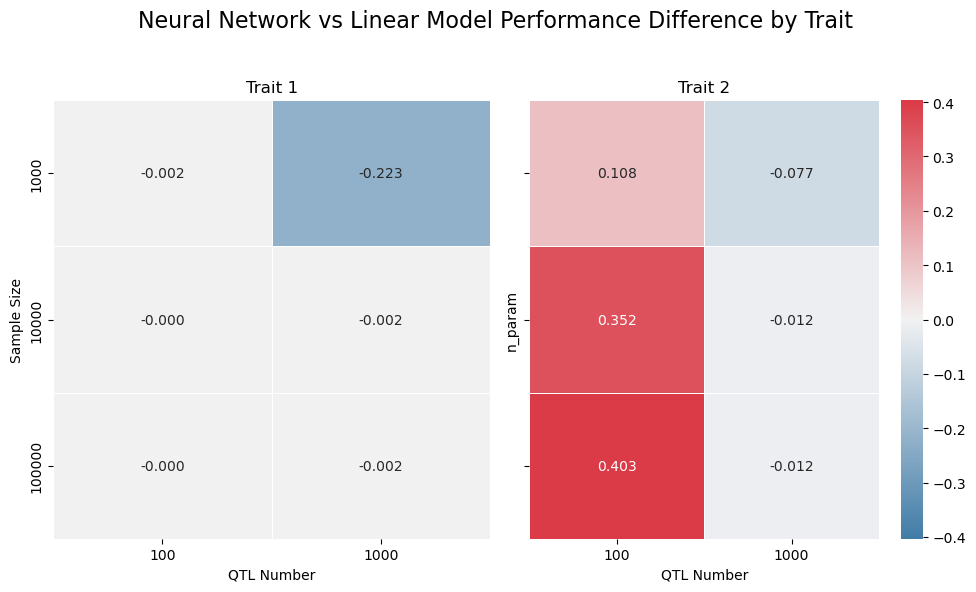

In [122]:
pl2 = plot_difference_heatmap(comparison_df)
pl2.show()